# Import all libraries

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2

# Import Data

In [44]:
# Load the diabetes dataset and select the columns you want
df = pd.read_csv('data/diabetes.csv')
print(df.shape)
print(df.info())


(768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


# Check for missing data

In [45]:
print(df.shape)
print(df.info())

(768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


# Check data correlation

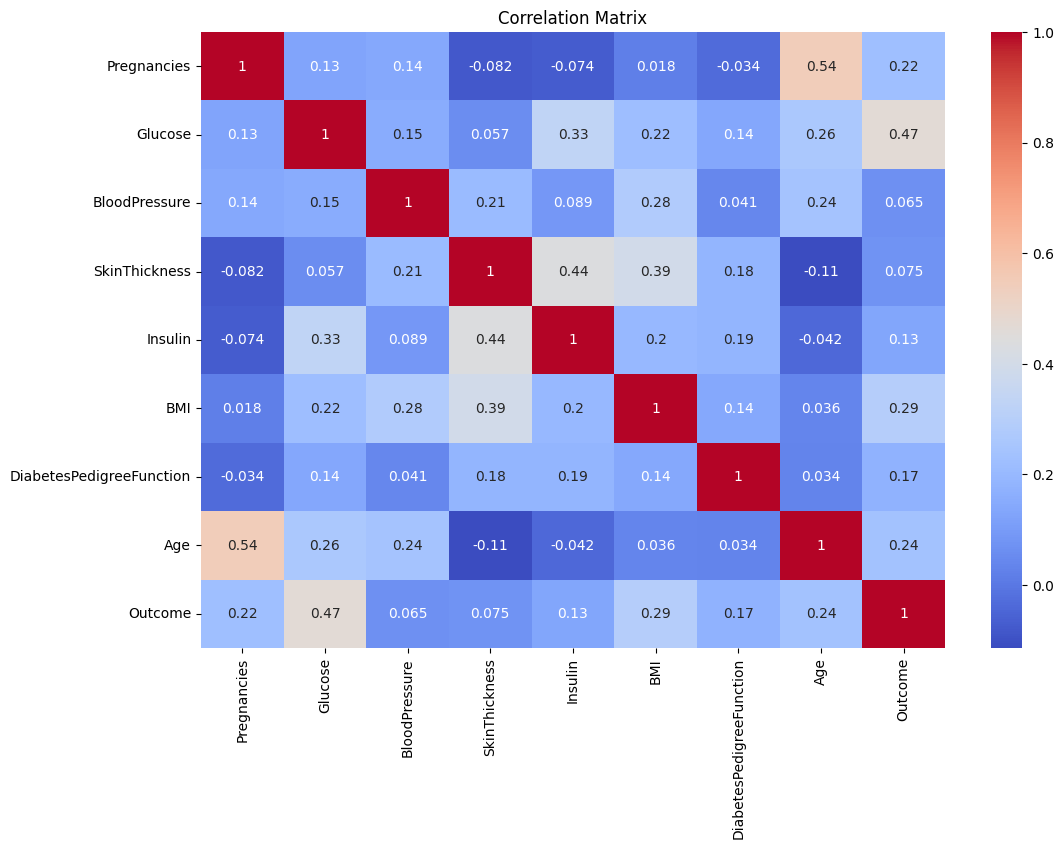

In [46]:
# Plot correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Split df into features df (X) and labels df (y)

In [47]:

# Separate the features and target variable
X = df.drop('Outcome', axis=1)
y = df['Outcome']
print(f"X shape: {X.shape}", f"y shape: {y.shape}")



X shape: (768, 8) y shape: (768,)


# Selecting 7 Best correlated features for knn

In [48]:
# Feature selection using chi-squared test (7 gave best result after manual testing)
k = 7
selector = SelectKBest(chi2, k=k)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support(indices=True)]

# Splitting DF into train and test sub dataframes

In [49]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=16)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (514, 8)
X_test: (254, 8)
y_train: (514,)
y_test: (254,)


# Looking for best n_neighbors hyperparameter

17 0.8031496062992126


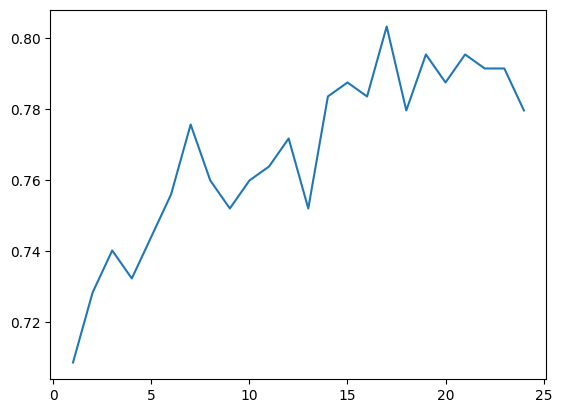

In [50]:
results = {}
for param in range(1,25):
    pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=param))
    pipeline.fit(X_train, y_train)
    y_hat = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_hat)
    results[param] = acc
best_param = max(results, key=results.get)
print(best_param, results[best_param])
plt.plot(results.keys(), results.values())

# Creating a pipeline that consists of standardization and KNN model

In [51]:
# Create a pipeline that scales the features and trains a KNN classifier
# Standard scaler transforms each feature so that it has a mean of 0 and a standard deviation of 1.
nb_pipeline = make_pipeline(StandardScaler(), GaussianNB())
knn_pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=best_param))

# Use KFold cross-validation to check how pipeline performs on each subframe of splitted dataframe

In [52]:
# Use cross-validation to evaluate the nb pipeline
cv = KFold(n_splits=5, shuffle=True)
scores = cross_val_score(nb_pipeline, X_train, y_train, cv=cv)
print("NB Cross-validation scores:", scores)
print("NB Mean accuracy: {:.3f}".format(scores.mean()))

# Use cross-validation to evaluate the knn pipeline
cv = KFold(n_splits=5, shuffle=True)
scores = cross_val_score(knn_pipeline, X_train, y_train, cv=cv)
print("KNN Cross-validation scores:", scores)
print("KNN Mean accuracy: {:.3f}".format(scores.mean()))

NB Cross-validation scores: [0.70873786 0.70873786 0.83495146 0.65048544 0.75490196]
NB Mean accuracy: 0.732
KNN Cross-validation scores: [0.75728155 0.68932039 0.74757282 0.65048544 0.66666667]
KNN Mean accuracy: 0.702


# Fitting model with train sets

In [53]:
# Train the NB pipeline on the full training set
nb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

In [54]:
# Train the KNN pipeline on the full training set
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=17))])

# Making predictions on test dataframe

In [55]:
# Make predictions on the testing data
y_hat_nb = nb_pipeline.predict(X_test)

# Make predictions on the testing data
y_hat_knn = knn_pipeline.predict(X_test)

# Evaluating model using accuracy and confusion matrix

NB Accuracy: 0.791
-------------------


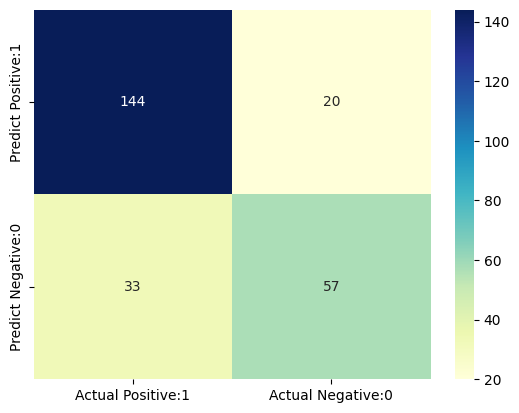

In [56]:
# Print accuracy and confusion matrix for nb
acc_nb = accuracy_score(y_test, y_hat_nb)
print("NB Accuracy: {:.3f}".format(acc_nb))
cm = confusion_matrix(y_test, y_hat_nb)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                         index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

print("-------------------")


KNN Accuracy: 0.803


<Axes: >

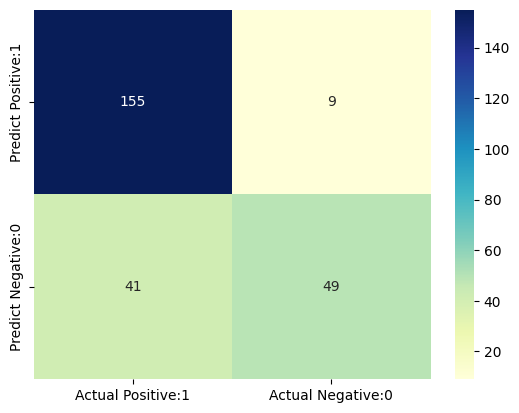

In [57]:
# Print accuracy and confusion matrix for knn
acc_knn = accuracy_score(y_test, y_hat_knn)
print("KNN Accuracy: {:.3f}".format(acc_knn))
cm = confusion_matrix(y_test, y_hat_knn)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                         index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')


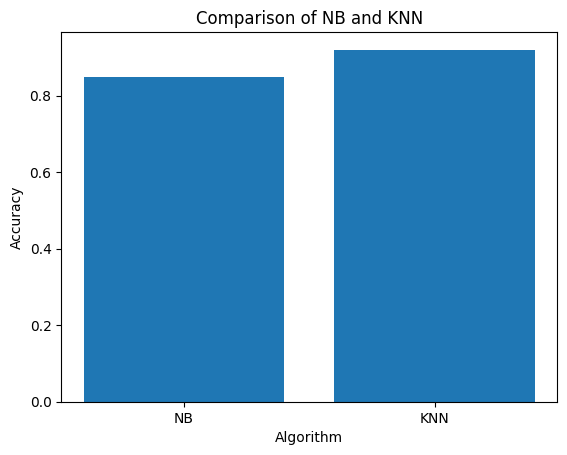

In [58]:
# define data
x = ['NB', 'KNN']
acc_nb = 0.85
acc_knn = 0.92
y = [acc_nb, acc_knn]

# create bar chart
plt.bar(x, y)

# set axis labels and title
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Comparison of NB and KNN')

# show the plot
plt.show()

# Calculate and Display ROC Curve

It is a plot of the true positive rate (TPR) against the false positive rate (FPR) for the different possible cutoffs of a binary classifier.

In [59]:
def calculateAndDisplayROCcurve(pipeline):

    # Compute ROC curve and AUC
    y_score = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    print("ROC AUC: {:.3f}".format(roc_auc))

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC curve (area = {:.3f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()


ROC AUC: 0.836


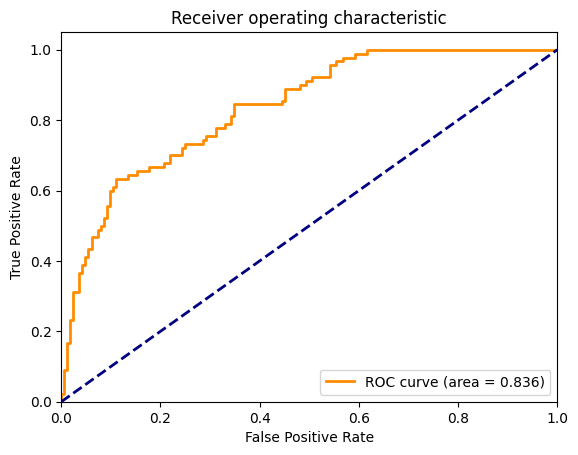

ROC AUC: 0.840


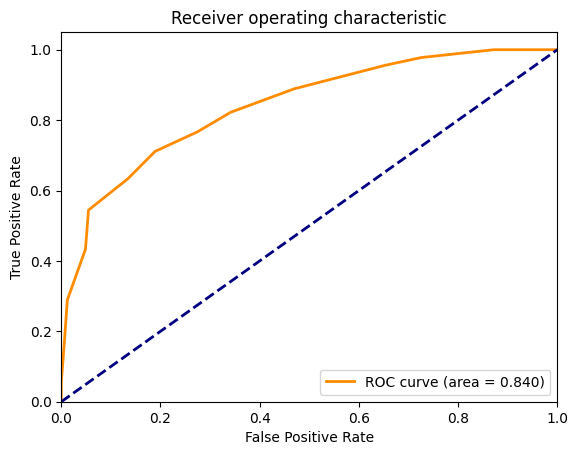

In [60]:
calculateAndDisplayROCcurve(pipeline=nb_pipeline)
calculateAndDisplayROCcurve(pipeline=knn_pipeline)

In [61]:
nb_pipeline = make_pipeline(StandardScaler(), GaussianNB())
knn3_pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))
knn5_pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
knn11_pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=11))
dt_pipeline = make_pipeline(StandardScaler(), DecisionTreeClassifier())
models = {"nb_pipeline":nb_pipeline, "knn3_pipeline":knn3_pipeline, "knn5_pipeline":knn5_pipeline, "knn11_pipeline":knn11_pipeline, "dt_pipeline":dt_pipeline}


In [69]:
# nb_pipeline = GaussianNB()
# knn3_pipeline = KNeighborsClassifier(n_neighbors=3)
# knn5_pipeline = KNeighborsClassifier(n_neighbors=5)
# knn11_pipeline = KNeighborsClassifier(n_neighbors=11)
# dt_pipeline = DecisionTreeClassifier()
# models = {"nb_pipeline":nb_pipeline, "knn3_pipeline":knn3_pipeline, "knn5_pipeline":knn5_pipeline, "knn11_pipeline":knn11_pipeline, "dt_pipeline":dt_pipeline}


In [66]:
for name, model in models.items():
    model.fit(X_train, y_train)

nb_pipeline Accuracy: 0.791


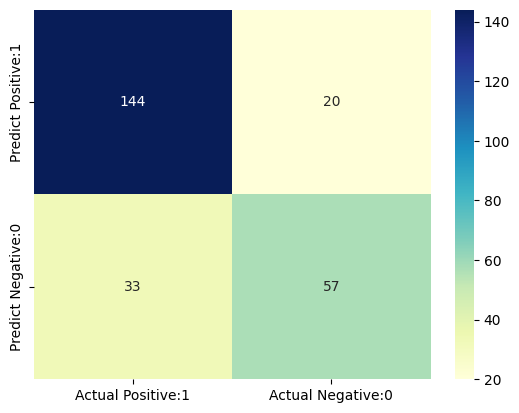

-------------------
knn3_pipeline Accuracy: 0.689


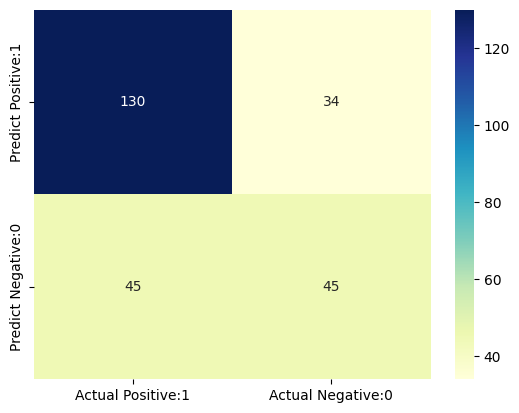

-------------------
knn5_pipeline Accuracy: 0.728


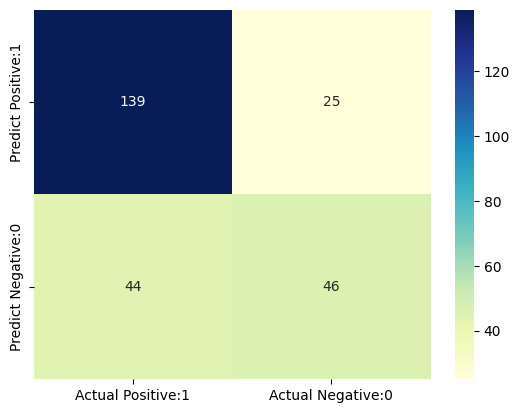

-------------------
knn11_pipeline Accuracy: 0.776


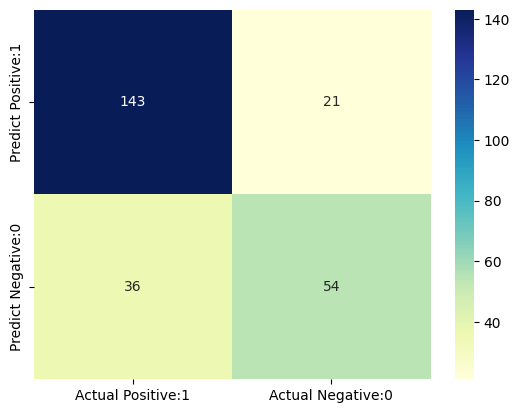

-------------------
dt_pipeline Accuracy: 0.697


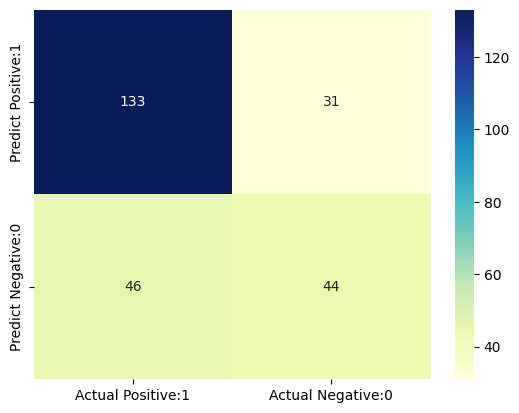

-------------------


In [67]:
scores = []
for name, model in models.items():
    y_hat = model.predict(X_test)

    # Print accuracy and confusion matrix for nb
    acc = accuracy_score(y_test, y_hat)
    scores.append(acc)
    print(f"{name}","Accuracy: {:.3f}".format(acc))
    cm = confusion_matrix(y_test, y_hat)
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                            index=['Predict Positive:1', 'Predict Negative:0'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.show()    
    print("-------------------")

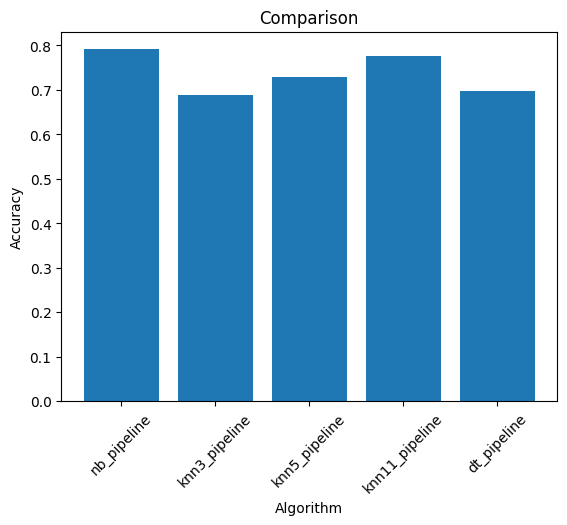

In [68]:
# define data
x = models.keys()

y = scores

# create bar chart
plt.bar(x, y)

# set axis labels and title
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.xticks(rotation = 45)
plt.title('Comparison')

# show the plot
plt.show()